In [8]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
import torchvision
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation_option1(num_classes):
    
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                        hidden_layer,
                                                        num_classes)
    
    return model

def get_model_instance_segmentation_option2(num_classes):
    
    # load a pre-trained model for classification and return
    # only the features
    backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
    
    # FasterRCNN needs to know the number of
    # output channels in a backbone. For mobilenet_v2, it's 1280
    # so we need to add it here
    backbone.out_channels = 1280
    
    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                    aspect_ratios=((0.5, 1.0, 2.0),))
    
    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)
    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                        num_classes=2,
                        rpn_anchor_generator=anchor_generator,
                        box_roi_pool=roi_pooler)
    return model

In [10]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
from engine import train_one_epoch, evaluate
import utils
from PIL import Image
import torch
import torchvision.transforms as transforms
import requests
import utils
#%matplotlib inline
import matplotlib.pyplot as plt

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# use our dataset and defined transformations
dataset = PennFudanDataset('/content/drive/MyDrive/Colab Notebooks/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('/content/drive/MyDrive/Colab Notebooks/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
                        dataset, batch_size=2, shuffle=True, num_workers=0,
                        collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
                        dataset_test, batch_size=1, shuffle=False, num_workers=0,
                        collate_fn=utils.collate_fn)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
#MODEL_OPTION1

# get the model using our helper function
model_option1 = get_model_instance_segmentation_option1(num_classes)

# move model to the right device
model_option1.to(device)

# construct an optimizer for option1
params = [p for p in model_option1.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler for the same
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
step_size=3,
gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10
print ("MODEL OPTION 1")

for epoch in range(num_epochs):
    print("Model 1 Epoch: {}".format(epoch))
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_option1, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model_option1, data_loader_test, device=device)

print ("\n")
print("That's it! Model 1")

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MODEL OPTION 1
Model 1 Epoch: 0
Epoch: [0]  [ 0/60]  eta: 0:01:56  lr: 0.000090  loss: 5.8660 (5.8660)  loss_classifier: 0.7740 (0.7740)  loss_box_reg: 0.3408 (0.3408)  loss_mask: 4.7247 (4.7247)  loss_objectness: 0.0241 (0.0241)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 1.9364  data: 1.3563  max mem: 2579
Epoch: [0]  [10/60]  eta: 0:01:33  lr: 0.000936  loss: 2.3789 (3.1197)  loss_classifier: 0.5083 (0.4910)  loss_box_reg: 0.3408 (0.2984)  loss_mask: 1.4818 (2.3071)  loss_objectness: 0.0192 (0.0185)  loss_rpn_box_reg: 0.0028 (0.0047)  time: 1.8733  data: 1.3209  max mem: 3528
Epoch: [0]  [20/60]  eta: 0:01:14  lr: 0.001783  loss: 0.9242 (2.0173)  loss_classifier: 0.2323 (0.3516)  loss_box_reg: 0.3054 (0.2896)  loss_mask: 0.4465 (1.3515)  loss_objectness: 0.0192 (0.0187)  loss_rpn_box_reg: 0.0030 (0.0059)  time: 1.8659  data: 1.3193  max mem: 3528
Epoch: [0]  [30/60]  eta: 0:00:56  lr: 0.002629  loss: 0.5756 (1.5340)  loss_classifier: 0.0937 (0.2659)  loss_box_reg: 0.2108 (0.2590)  los

In [14]:
#MODEL_OPTION2

model_option2 = get_model_instance_segmentation_option2(num_classes)
model_option2.to(device)

# construct an optimizer for option2
params = [p for p in model_option2.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler for the same
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
step_size=3,
gamma=0.1)

print ("MODEL OPTION 2")

for epoch in range(num_epochs):

    print("Model 2 Epoch: {}".format(epoch))
    
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_option2, optimizer, data_loader, device, epoch, print_freq=10)
    
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    evaluate(model_option2, data_loader_test, device=device)

print ("\n")
print("That's it! Model 2")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MODEL OPTION 2
Model 2 Epoch: 0
Epoch: [0]  [ 0/60]  eta: 0:00:36  lr: 0.000090  loss: 1.5483 (1.5483)  loss_classifier: 0.7352 (0.7352)  loss_box_reg: 0.0793 (0.0793)  loss_objectness: 0.7081 (0.7081)  loss_rpn_box_reg: 0.0257 (0.0257)  time: 0.6098  data: 0.0252  max mem: 4110
Epoch: [0]  [10/60]  eta: 0:00:20  lr: 0.000936  loss: 1.4805 (1.4755)  loss_classifier: 0.6844 (0.6521)  loss_box_reg: 0.0793 (0.0757)  loss_objectness: 0.6987 (0.6954)  loss_rpn_box_reg: 0.0506 (0.0523)  time: 0.4007  data: 0.0353  max mem: 5714
Epoch: [0]  [20/60]  eta: 0:00:15  lr: 0.001783  loss: 1.1994 (1.2825)  loss_classifier: 0.4023 (0.4896)  loss_box_reg: 0.0807 (0.0973)  loss_objectness: 0.6620 (0.6526)  loss_rpn_box_reg: 0.0349 (0.0430)  time: 0.3801  data: 0.0346  max mem: 6171
Epoch: [0]  [30/60]  eta: 0:00:11  lr: 0.002629  loss: 1.0186 (1.1833)  loss_classifier: 0.2883 (0.4310)  loss_box_reg: 0.1316 (0.1218)  loss_objectness: 0.5236 (0.5883)  loss_rpn_box_reg: 0.0349 (0.0421)  time: 0.3802  data

Original Image


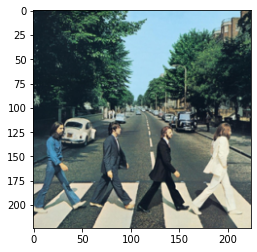

OPTION 1
Prediction for model_option1: 
 [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0'), 'masks': tensor([], device='cuda:0', size=(0, 1, 224, 224))}]


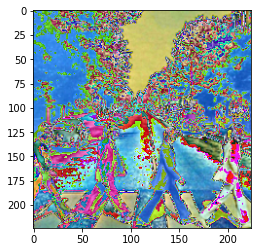

OPTION 2
Prediction for model_option2: 
 [{'boxes': tensor([[ 61.7875,  91.8146, 108.8170, 217.9420],
        [  7.7791,  82.5294,  56.8638, 224.0000],
        [176.3702, 120.4357, 223.9798, 224.0000],
        [ 64.7320, 133.9791,  87.6553, 202.6269],
        [ 60.2962,  63.2871, 143.0251, 224.0000],
        [ 17.7155,  75.2567,  99.8058, 223.7091],
        [ 95.4509,  26.1168, 119.9425,  81.9522],
        [105.6704,  25.2083, 129.5414,  83.2234],
        [  9.1040, 102.0064, 196.3956, 219.8465],
        [ 54.6946,   3.4210, 136.3288, 107.8350]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3437, 0.2554, 0.1789, 0.1712, 0.1502, 0.1249, 0.1001, 0.0676, 0.0614,
        0.0581], device='cuda:0')}]


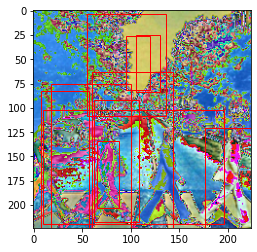

In [15]:
\